## Introducing libraries, populations, and parameters

In [164]:
# importing relevant libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [165]:
# read in population matrix
# https://population.un.org/wpp/Download/Standard/Population/
population = pd.read_excel(r"C:", sheet_name = "", usecols = 'I:X')
popn = population.iloc[8:9]
total_pop = popn.sum().sum()
popn = popn.to_numpy()
popn = popn[0] # convert to 1d array

In [166]:
# Susceptibility, for scaling matrices (Davies et al.)
omega = [0.4, 0.4, 0.38, 0.38, 0.79, 0.79, 0.86, 0.86, 0.8, 0.8, 0.82, 0.82, 0.88, 0.88, 0.74, 0.74]

In [167]:
# read in contact matrices
# see Prem et al. 2017 for projections
df_allc = pd.read_excel(r"", usecols = 'B:Q') # read in
AllC = df_allc.iloc[2:18] # take desired rows
AllC = AllC.multiply(omega, axis=1)
AllC = AllC.to_numpy() # infection rate matrix for All contacts, BEFORE multiplying by B

In [168]:
# Reproductive number (from literature estimates)
R0 = 3

# Proportion of infections arising from presymptomatic infectives (Ferretti et al.)
prop_p = 0.489;
# Proportion of infections arising from asymptomatic infectives
prop_a = 0.106
# Proportion from symptomatic
prop_s = 1-prop_p-prop_a

# Proportions - xi (Davies et al.)
xi = [0.71,0.71,0.79,0.79,0.73,0.73,0.67,0.67,0.6,0.6,0.51,0.51,0.37,0.37,0.31,0.31]

# Recover - Lambda, mu, nu (can't use name lambda)
Lambda = 0.5
mu = 0.125
nu = 0.1

# Isolation - rho, sigma (toggle)
rho0 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # added a '0' to avoid accidental redefining if 'rho' is mentioned later
sig0 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [169]:
# calculations to determine B, eta, and theta before intervention
# after calculating, they are held constant. what varies is the contact matrix, e.g. through removing school contacts

# determine relative contributions to R from each group
cont_a = sum([popn[k]*xi[k]*sum([AllC[k][l]/(nu+sig0[k]) for l in range(16)]) for k in range(16)])
cont_p = sum([popn[k]*(1-xi[k])*sum([AllC[k][l]/(Lambda+sig0[k]) for l in range(16)]) for k in range(16)])
cont_s = sum([popn[k]*(1-xi[k])*sum([AllC[k][l]/(Lambda+sig0[k]) for l in range(16)])*Lambda/(mu+rho0[k]) for k in range(16)])

# we want the ratio prop_p/prop_s to equal eta times cont_p/cont_s. similar for theta
eta = (cont_s/cont_p)*(prop_p/prop_s)
theta = (cont_s/cont_a)*(prop_a/prop_s) # much smaller as prop_a is small and young people have more contacts

# calculate B from R0 = B*(sum of terms in R expression)
total_sum = (cont_s+eta*cont_p+theta*cont_a)/total_pop
B = R0/total_sum

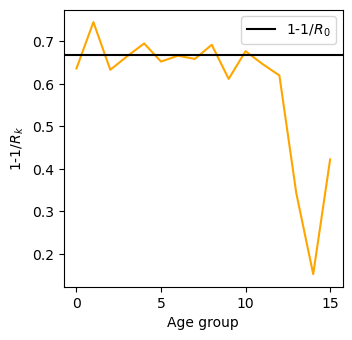

In [170]:
# compare 1-1/R0 to 1-1/Rk for each group k
R_conts = []

for k in range(16):
    z = 0
    for l in range(16):
        a_cont = xi[k]*theta*AllC[k][l]/(nu+sig0[k])
        p_cont = (1-xi[k])*eta*AllC[k][l]/(Lambda+sig0[k])
        s_cont = (1-xi[k])*(Lambda/(Lambda+sig0[k]))*AllC[k][l]/(mu+rho0[k])
        z = z+a_cont+p_cont+s_cont
    R_conts.append(B*z) # R value for each group

sir_probs = []
for x in R_conts:
    sir_probs.append(1-1/x) # determine 1-1/Rk for each group

plt.figure(figsize=(3.6,3.6))
plt.plot(sir_probs, color = 'orange', label = '_nolegend_')
plt.axhline(y = 2/3, color = 'black', label = '1-1/$R_0$')
plt.xlabel('Age group')
plt.ylabel('1-1/$R_k$')
plt.legend()

## Functions to obtain R value and probability of local outbreak

In [171]:
# calculate value of R. beta represents the RATE matrix after any deductions, i.e. CM rescaled by omega and B

def get_R_value(beta, rho, sig): 
    
    a_cont = sum([popn[k]*xi[k]*sum([beta[k][l]/(nu+sig[k]) for l in range(16)]) for k in range(16)])
    p_cont = sum([popn[k]*(1-xi[k])*sum([beta[k][l]/(Lambda+sig[k]) for l in range(16)]) for k in range(16)])
    s_cont = sum([popn[k]*(1-xi[k])*sum([beta[k][l]/(Lambda+sig[k]) for l in range(16)])*Lambda/(mu+rho[k]) for k in range(16)])
    
    sums = (s_cont+eta*p_cont+theta*a_cont)/total_pop
    
    return sums

print(get_R_value(AllC*B, rho0, sig0)) # should return 3

3.0


In [172]:
# calculate probability of a local outbreak using formulas based on group of initial infection
# args must be rate matrix (beta), rho, and sigma, in that order

from scipy.optimize import fsolve

def prob_system(vars, *args):
    beta = args[0] # extract each variable
    rho = args[1]
    sig = args[2]
    x = vars[:16] # extract x, y, and z's
    y = vars[16:32]
    z = vars[32:]
    
    x_eqns = [x[k]-x[k]*sum(beta[k][j]*(xi[j]*z[j]+(1-xi[j])*y[j])/(mu+rho[k]+sum(beta[k][l] for l in range(16))) for j in range(16))-(mu+rho[k])/(mu+rho[k]+sum(beta[k][l] for l in range(16))) for k in range(16)]
    
    y_eqns = [y[k]-y[k]*eta*sum(beta[k][j]*(xi[j]*z[j]+(1-xi[j])*y[j])/(Lambda+sig[k]+eta*sum(beta[k][l] for l in range(16))) for j in range(16))-Lambda*x[k]/(Lambda+sig[k]+eta*sum(beta[k][l] for l in range(16)))-sig[k]/(Lambda+sig[k]+eta*sum(beta[k][l] for l in range(16))) for k in range(16)]
    
    z_eqns = [z[k]-z[k]*theta*sum(beta[k][j]*(xi[j]*z[j]+(1-xi[j])*y[j])/(nu+sig[k]+theta*sum(beta[k][l] for l in range(16))) for j in range(16))-(nu+sig[k])/(nu+sig[k]+theta*sum(beta[k][l] for l in range(16))) for k in range(16)]
    
    return x_eqns + y_eqns + z_eqns

def get_pk_values(beta, rho, sig):
    
    soln = fsolve(prob_system, [0]*48, args = (beta, rho, sig))
    x = soln[:16]
    y = soln[16:32]
    z = soln[32:]
    pk_values = [xi[k]*(1-z[k])+(1-xi[k])*(1-y[k]) for k in range(16)]
    
    return pk_values

In [173]:
# obtain weighted average probability

def get_PMO(probs):
    PMO = sum(popn[k]*probs[k] for k in range(16))/total_pop
    return PMO

In [174]:
# checking code works on baseline values before exploring intervention

probs = get_pk_values(AllC*B, rho0, sig0) # takes in rate matrix, rho, and sigma
print(probs)

PMO = get_PMO(probs)
print(PMO)

[0.3326973849525848, 0.38508104364003876, 0.3035300442309919, 0.3147078719265254, 0.34883052985900964, 0.33361879083409013, 0.36072919972532314, 0.35855910974321115, 0.39964535729054074, 0.36596789164517585, 0.42846301043024926, 0.41394057060136635, 0.44817262781175676, 0.3336675532890566, 0.2932493443201847, 0.3701886522062542]
0.3505788229861218


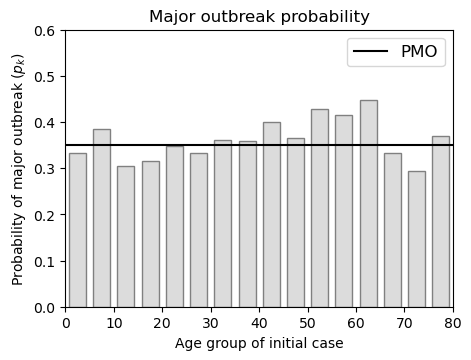

In [175]:
# plot baseline probabilities (toggle initially for constant omega and xi)
ages = np.arange(5, 85, 5)
width = 3.5
plt.figure(figsize=(5,3.6))
plt.bar(ages-2.5, probs, width, color = 'gainsboro', edgecolor = 'grey')
plt.axhline(y=PMO, label = 'PMO', color = 'black')

plt.xlabel('Age group of initial case')
plt.ylabel('Probability of major outbreak ($p_k$)')
plt.title('Major outbreak probability')
plt.xlim([0,80])
plt.ylim([0,0.6])
plt.legend(prop={'size':12})

## Load in and rescale all contact matrices

In [176]:
# Read in each contact matrix

df_all = pd.read_excel(r"C:", usecols = 'B:Q')
All = df_all.iloc[2:18]
    
df_school = pd.read_excel(r"C:", sheet_name = "", usecols = 'B:Q')
School = df_school.iloc[2:18]
    
df_work = pd.read_excel(r"C:", sheet_name = "", usecols = 'B:Q')
Work = df_work.iloc[2:18]
    
df_home = pd.read_excel(r"C:", sheet_name = "", usecols = 'B:Q')
Home = df_home.iloc[2:18]
    
df_other = pd.read_excel(r"C:", sheet_name = "", usecols = 'B:Q')
Other = df_other.iloc[2:18]
    
# Rescale each and convert to numpy array

omega = [0.4, 0.4, 0.38, 0.38, 0.79, 0.79, 0.86, 0.86, 0.8, 0.8, 0.82, 0.82, 0.88, 0.88, 0.74, 0.74]
B = 0.04752483126556439

All = All.multiply(omega, axis=1)
All = All.to_numpy()
All = All*B

School = School.multiply(omega, axis=1)
School = School.to_numpy()
School = School*B

Work = Work.multiply(omega, axis=1)
Work = Work.to_numpy()
Work = Work*B

Home = Home.multiply(omega, axis=1)
Home = Home.to_numpy()
Home = Home*B

Other = Other.multiply(omega, axis=1)
Other = Other.to_numpy()
Other = Other*B

## Explore the effect of reducing specific contacts

In [177]:
# Key ingredient: reduce components of the contact matrix and feed it in to get_pk_values

ages = np.arange(5, 85, 5)

all_probs = get_pk_values(All, rho0, sig0)
all_PMO = get_PMO(all_probs)

0.3505788229861218
0.3226514722077205
[0.012321806812106761, 0.05154096635233524, 0.043433572734164316, 0.044287820481944906, 0.017114456730150662, 0.015660912704357433, 0.017566006578561222, 0.015077856356410457, 0.01487878531148068, 0.019996106089257948, 0.02199412156658742, 0.021347439067641083, 0.021371069138271914, 0.021501631789443143, 0.02757877675952919, 0.01831229132618606]


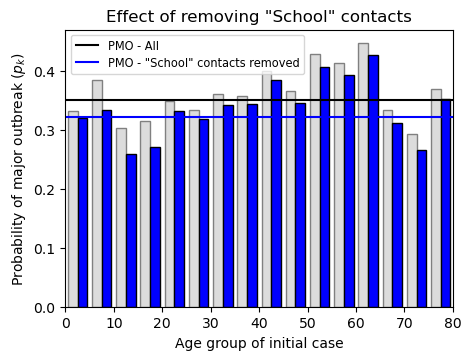

In [178]:
# No school contacts
no_sch_probs = get_pk_values(All-School, rho0, sig0)
no_sch_PMO = get_PMO(no_sch_probs)

width = 2
plt.figure(figsize=(5,3.6))
plt.bar(ages-3.5, all_probs, width, color = 'gainsboro', edgecolor = 'grey')
plt.axhline(y=all_PMO, label = 'PMO - All', color = 'black')

plt.bar(ages-1.5, no_sch_probs, width, color = 'blue', edgecolor = 'black')
plt.axhline(y=no_sch_PMO, label = 'PMO - "School" contacts removed', color = 'blue')

plt.xlabel('Age group of initial case')
plt.ylabel('Probability of major outbreak ($p_k$)')
plt.title('Effect of removing "School" contacts')
plt.xlim([0,80])
plt.legend(prop={'size':8.2})

print(all_PMO)
print(no_sch_PMO)
print([all_probs[i]-no_sch_probs[i] for i in range(16)]) # assess which age group is more affected

0.3505788229861218
0.2758783571307385
[0.036064000850862366, 0.02810681958027733, 0.02739946041349023, 0.03991114047032873, 0.06667454132324102, 0.09836929031310018, 0.11692231031358682, 0.12966436260846478, 0.16477926147291824, 0.16260881108096237, 0.20112505621657167, 0.15918552259437002, 0.18397357734804315, 0.05823996990298419, 0.05839983353611353, 0.06495219063025037]


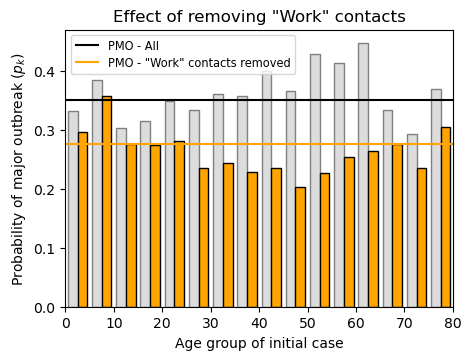

In [179]:
# No work contacts
no_work_probs = get_pk_values(All-Work, rho0, sig0)
no_work_PMO = get_PMO(no_work_probs)

width = 2
plt.figure(figsize=(5,3.6))
plt.bar(ages-3.5, all_probs, width, color = 'gainsboro', edgecolor = 'grey')
plt.axhline(y=all_PMO, label = 'PMO - All', color = 'black')

plt.bar(ages-1.5, no_work_probs, width, color = 'orange', edgecolor = 'black')
plt.axhline(y=no_work_PMO, label = 'PMO - "Work" contacts removed', color = 'orange')

plt.xlabel('Age group of initial case')
plt.ylabel('Probability of major outbreak ($p_k$)')
plt.title('Effect of removing "Work" contacts')
plt.xlim([0,80])
plt.legend(prop={'size':8.2})

print(all_PMO)
print(no_work_PMO)
print([all_probs[i]-no_work_probs[i] for i in range(16)]) # assess which age group is more affected

0.3505788229861218
0.22288652745626542
[0.1773912275456739, 0.15400381364235013, 0.1467606823881681, 0.14131350917016514, 0.14493395627857344, 0.1070855477462197, 0.08997793514529434, 0.08225399348699064, 0.07338144251411938, 0.06533713053779389, 0.06922654892737873, 0.06996454357277981, 0.08964774536140957, 0.10605380706296916, 0.09712860201649579, 0.09315481661893121]


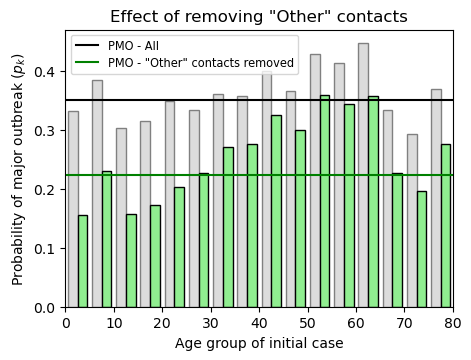

In [180]:
# No other contacts
no_oth_probs = get_pk_values(All-Other, rho0, sig0)
no_oth_PMO = get_PMO(no_oth_probs)

width = 2
plt.figure(figsize=(5,3.6))
plt.bar(ages-3.5, all_probs, width, color = 'gainsboro', edgecolor = 'grey')
plt.axhline(y=all_PMO, label = 'PMO - All', color = 'black')

plt.bar(ages-1.5, no_oth_probs, width, color = 'lightgreen', edgecolor = 'black')
plt.axhline(y=no_oth_PMO, label = 'PMO - "Other" contacts removed', color = 'green')

plt.xlabel('Age group of initial case')
plt.ylabel('Probability of major outbreak ($p_k$)')
plt.title('Effect of removing "Other" contacts')
plt.xlim([0,80])
plt.legend(prop={'size':8.2})

print(all_PMO)
print(no_oth_PMO)
print([all_probs[i]-no_oth_probs[i] for i in range(16)]) # assess which age group is more affected

In [181]:
# Effect of reductions on average probability of major outbreak

reductions = [x for x in range(101)]

sch = []
wrk = []
oth = []
for red in reductions:
    sch.append(get_PMO(get_pk_values(All-School*(red/100), rho0, sig0)))
    wrk.append(get_PMO(get_pk_values(All-Work*(red/100), rho0, sig0)))
    oth.append(get_PMO(get_pk_values(All-Other*(red/100), rho0, sig0)))

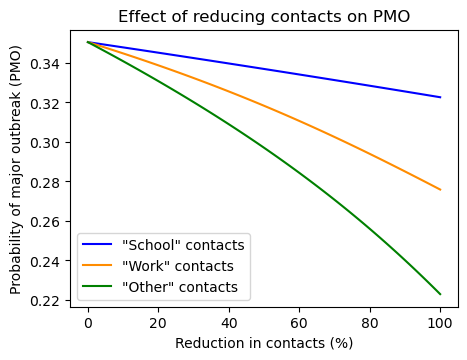

In [182]:
plt.figure(figsize=(5,3.6))
plt.plot(reductions, sch, label = '"School" contacts', color = 'blue')
plt.plot(reductions, wrk, label = '"Work" contacts', color = 'darkorange')
plt.plot(reductions, oth, label = '"Other" contacts', color = 'green')
plt.xlabel('Reduction in contacts (%)')
plt.ylabel('Probability of major outbreak (PMO)')
plt.title('Effect of reducing contacts on PMO')
plt.legend(prop={'size':10})

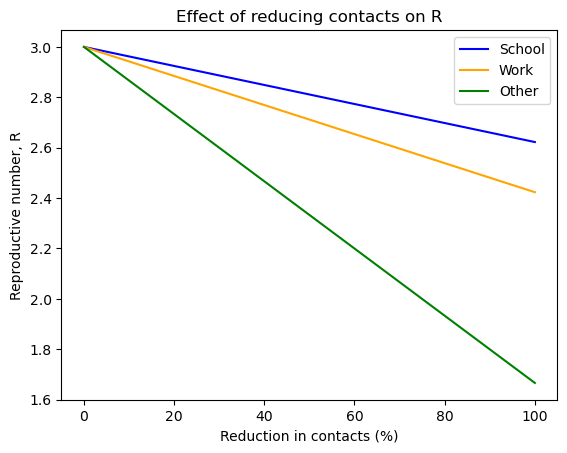

In [183]:
# Effect of reductions on R

reductions = [x for x in range(101)]
schR = []
wrkR = []
othR = []
for red in reductions:
    schR.append(get_R_value(All-School*(red/100), rho0, sig0))
    wrkR.append(get_R_value(All-Work*(red/100), rho0, sig0))
    othR.append(get_R_value(All-Other*(red/100), rho0, sig0))
    
plt.plot(reductions, schR, label = 'School', color = 'blue')
plt.plot(reductions, wrkR, label = 'Work', color = 'orange')
plt.plot(reductions, othR, label = 'Other', color = 'green')
plt.xlabel('Reduction in contacts (%)')
plt.ylabel('Reproductive number, R')
plt.title('Effect of reducing contacts on R')
plt.legend()
plt.show()

## Explore the effect of isolation

0.3002494210499901


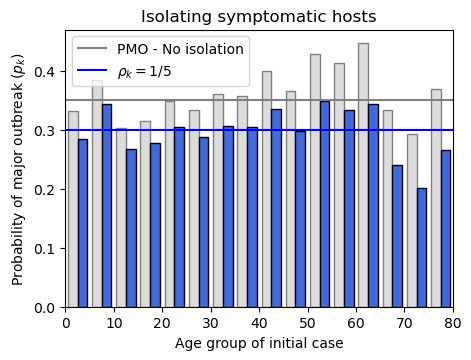

In [184]:
# Key ingredient: increase rho and sigma and feed them in to get_pk_values

rho_symp = [0.2]*16
symp_iso = get_pk_values(All, rho_symp, sig0)
symp_PMO = get_PMO(symp_iso)

plt.figure(figsize=(5,3.6))
plt.bar(ages-3.5, all_probs, width, color = 'gainsboro', edgecolor = 'grey')
plt.axhline(y=all_PMO, label = 'PMO - No isolation', color = 'grey')

plt.bar(ages-1.5, symp_iso, width, color = 'royalblue', edgecolor = 'black')
plt.axhline(y=symp_PMO, label = r'$\rho_k=1/5$', color = 'blue')

plt.xlabel('Age group of initial case')
plt.ylabel('Probability of major outbreak ($p_k$)')
plt.title('Isolating symptomatic hosts')
plt.xlim([0,80])
plt.legend(prop={'size':10})

print(symp_PMO)

0.16789840740821968


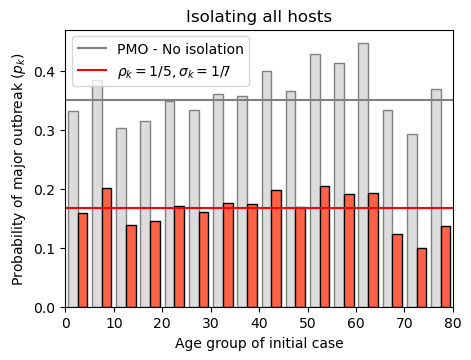

In [185]:
rho_new = [1/5]*16
sig_new = [1/7]*16
new_iso = get_pk_values(All, rho_new, sig_new)
new_PMO = get_PMO(new_iso)

plt.figure(figsize=(5,3.6))
plt.bar(ages-3.5, all_probs, width, color = 'gainsboro', edgecolor = 'grey')
plt.axhline(y=all_PMO, label = 'PMO - No isolation', color = 'grey')

plt.bar(ages-1.5, new_iso, width, color = 'tomato', edgecolor = 'black')
plt.axhline(y=new_PMO, label = r'$\rho_k=1/5, \sigma_k=1/7$', color = 'red')

plt.xlabel('Age group of initial case')
plt.ylabel('Probability of major outbreak ($p_k$)')
plt.title('Isolating all hosts')
plt.xlim([0,80])
plt.legend(prop={'size':10})

print(new_PMO)

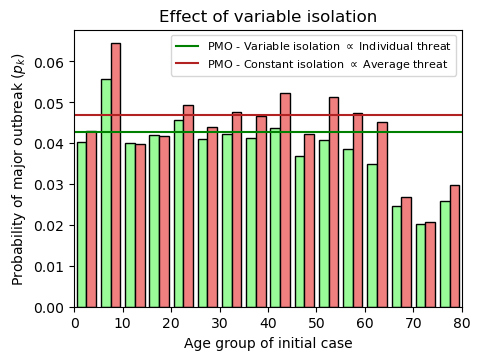

In [186]:
# compare age-dependent isolation vs constant isolation

variable_iso = get_pk_values(All, all_probs, all_probs)
constant_iso = get_pk_values(All, [all_PLO]*16, [all_PLO]*16)

var_iso_PMO = get_PMO(variable_iso)
con_iso_PMO = get_PMO(constant_iso)

plt.figure(figsize=(5,3.6))
plt.bar(ages-3.5, variable_iso, width, color = 'palegreen', edgecolor = 'black')
plt.axhline(y=var_iso_PMO, label = 'PMO - Variable isolation $\propto$ Individual threat', color = 'green')

plt.bar(ages-1.5, constant_iso, width, color = 'lightcoral', edgecolor = 'black')
plt.axhline(y=con_iso_PMO, label = 'PMO - Constant isolation $\propto$ Average threat', color = 'firebrick')

plt.xlabel('Age group of initial case')
plt.ylabel('Probability of major outbreak ($p_k$)')
plt.title('Effect of variable isolation')
plt.xlim([0,80])
plt.legend(prop={'size':8})

In [187]:
# explore detectability factor

dim = 10 # number of divisions
PMOs = [[0 for r in range(dim)] for d in range(dim)]

rates = [(1+R)/dim for R in range(dim)]
dets = [(1+D)/dim for D in range(dim)]

for r in range(dim):
    for d in range(dim):
        rho = [rates[r]]*16
        sig = [dets[d]*rates[r]]*16
        all_probs = get_pk_values(All, rho, sig)
        all_PMO = get_PMO(all_probs)
        PMOs[d][r] = all_PMO

Text(0.5, 1.0, 'Effect of relative isolation rates')

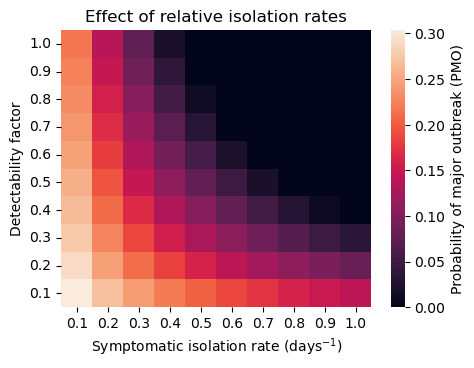

In [188]:
# the heatmap itself

plt.figure(figsize=(5,3.6))
ax = sns.heatmap(PMOs, cbar_kws={'label': 'Probability of major outbreak (PMO)'})
ax.invert_yaxis()
plt.xticks([x+1/2 for x in range(dim)], [round(rate,1) for rate in rates])
plt.yticks([y+1/2 for y in range(dim)], [round(det,1) for det in dets])
plt.yticks(rotation=0)
plt.xlabel('Symptomatic isolation rate (days$^{-1}$)')
plt.ylabel('Detectability factor')
plt.title('Effect of relative isolation rates')

## Explore the effect of combined efforts

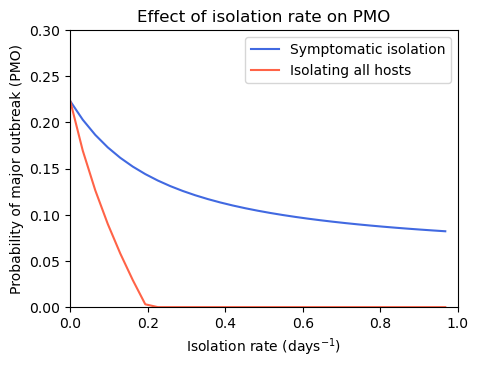

In [189]:
# Key ingredient: alter contact matrix AND isolation rates, then feed in to get_pk_values

iso_rates = [R/31 for R in range(31)]

symp_probs = []
asymp_probs = []
for rate in iso_rates:
    symp_probs.append(get_PMO(get_pk_values(All-Other, [rate]*16, sig0))) # removing other contacts
    asymp_probs.append(get_PMO(get_pk_values(All-Other, [rate]*16, [rate]*16)))
    
plt.figure(figsize=(5,3.6))
plt.plot(iso_rates, symp_probs, label = 'Symptomatic isolation', color = 'royalblue')
plt.plot(iso_rates, asymp_probs, label = 'Isolating all hosts', color = 'tomato')
plt.xlabel('Isolation rate (days$^{-1}$)')
plt.ylabel('Probability of major outbreak (PMO)')
plt.title('Effect of isolation rate on PMO')
plt.xlim([0,1])
plt.ylim([0,0.3])
plt.legend(prop={'size':10})

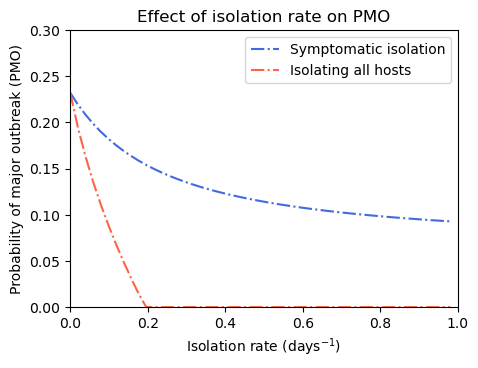

In [190]:
iso_rates = [R/51 for R in range(51)]

symp_probs = []
asymp_probs = []
for rate in iso_rates:
    symp_probs.append(get_PMO(get_pk_values(All-School-Work, [rate]*16, sig0))) # removing work and school contacts
    asymp_probs.append(get_PMO(get_pk_values(All-School-Work, [rate]*16, [rate]*16)))
    
plt.figure(figsize=(5,3.6))
plt.plot(iso_rates, symp_probs, label = 'Symptomatic isolation', color = 'royalblue', linestyle='dashdot')
plt.plot(iso_rates, asymp_probs, label = 'Isolating all hosts', color = 'tomato', linestyle='dashdot')
plt.xlabel('Isolation rate (days$^{-1}$)')
plt.ylabel('Probability of major outbreak (PMO)')
plt.title('Effect of isolation rate on PMO')
plt.xlim([0,1])
plt.ylim([0,0.3])
plt.legend(prop={'size':10})

In [191]:
# effect of reducing school and work contacts

dim = 10 # number of divisions
PMOs_comb = [[0 for r in range(dim)] for d in range(dim)]

schools = [100*(1+S)/dim for S in range(dim)]
works = [100*(1+W)/dim for W in range(dim)]

for s in range(dim):
    for w in range(dim):
        all_probs = get_pk_values(All-School*(schools[s]/100)-Work*(works[w]/100), rho0, sig0)
        all_PMO = get_PMO(all_probs)
        PMOs_comb[w][s] = all_PMO

Text(0.5, 1.0, 'Effect of contact reduction on PMO')

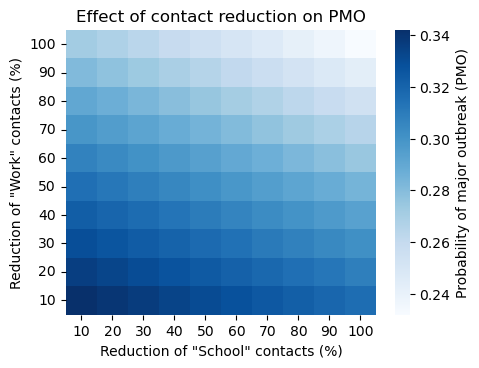

In [192]:
# heatmap

plt.figure(figsize=(5,3.7))
ax = sns.heatmap(PMOs_comb, cmap='Blues', cbar_kws={'label': 'Probability of major outbreak (PMO)'})
ax.invert_yaxis()
plt.xticks([x+1/2 for x in range(dim)], [round(sch) for sch in schools])
plt.yticks([y+1/2 for y in range(dim)], [round(wrk) for wrk in works])
plt.yticks(rotation=0)
plt.xlabel('Reduction of "School" contacts (%)')
plt.ylabel('Reduction of "Work" contacts (%)')
plt.title('Effect of contact reduction on PMO')